# Ensemble Learning

Last revision: Wed  29 Dec 2021 5:15:00 AEST

Author: Omar Ghattas

## Introduction

In this lab we will explore one of the most important areas in machine learning, ensemble methods. We will dive deeper into the bias-variance decomposition, and then work through detailed examples of Bagging and Adaptive Boosting, two algorithms that have become central to modern day machine learning. In each section, the goal will be to illustrate the concept both mathematically and then through code, and then we follow up with a short explanation of existing implementations that you should use in practice. It is important to understand how these algorithms work and so you are strongly encouraged to try to write simple implementations of these algorithms in Python, even if we do not end up using these in practice.

**Note: this notebook has only been tested using Python 3.**

### Acknowledgements:
Random Forest Regression Section: this section (only) was taken from the the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas (one of the original sklearn developers); the original content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

### Bias-Variance Decomposition: So what?

Recall the bias-variance discussion in both Lab2 and the Regression 2 Tutorial. Up till now, we have focused on understanding what the Bias-Variance decomposition means, but we haven't really seen why it is such an important concept. In the rest of the lab we will explore how the decomposition has motivated the invention of many important learning algorithms, such as Random Forests.

## Ensemble Learning: Bootstrap Aggregation (Bagging)

The Bias-Variance Decomposition tells us that a good learning algorithm is one that has low bias and low variance. Bootstrap Aggregation (Bagging) is an algorithm that attempts to build better models by reducing variance. Let's consider the example of a decision tree. Note that for this case, we will focus on classification error, and so the bias-variance decomposition does not have the same mathematical derivation as we saw above for the regression case with squared error, but the bias and variance still play analagous roles. 

In the following, we will repeat our analysis from before but for classification trees. We generate 9 datasets using the `make_blobs` function, so that all have the same cluster centers but points are sampled with some noise. We then build a decision tree of `max_depth=3` to each dataset and visualise. The idea will be to show that Decision Trees exhibit very high variance, which should be expected since we know that given enough depth, decision trees can fit any surface.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

# Helper function for visualising classifiers and decision surfaces    
def visualize_classifier(model, X, y, ax=None, cmap='rainbow', title=None):
    
    # reference: Python Data Science Handbook by Jake VanderPlas
    ax = ax or plt.gca()
    
    # Plot the training points
    
    if np.any(y==-1):
        y[y==-1] = 0.   # fix to get scatter c=y arg working when we use -1,1 coding
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                        clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # compute predictions on grid
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    if np.any(Z==-1):     # fix to get c=y working
        Z[Z==-1] = 0

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    if title:
        ax.set_title(title)

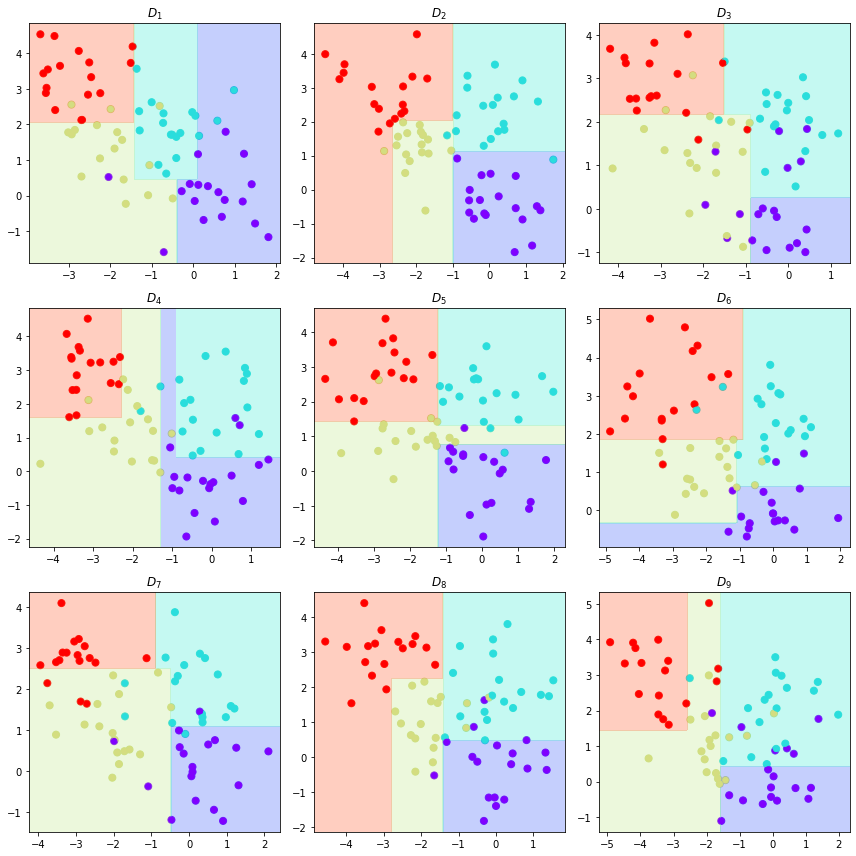

In [3]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
centers = [[0,0], [0,2], [-2,1], [-3,3]]
for j, ax in enumerate(ax.flat):
    X, y = make_blobs(n_samples=70, 
                      centers=centers, 
                      random_state=j, 
                      cluster_std=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    model = DecisionTreeClassifier(max_depth=3).fit(X,y)
    visualize_classifier(model, X, y, ax=ax, title=f"$D_{j+1}$")
    
plt.tight_layout()
plt.show()

It is clear from the above plots that given different datasets from the true clusters, Decision trees can fit a very wide range of models (different partitions of the input space), and so can very easily overfit.

Exercises:
1. Try increasing the max_depth parameter of the Decision Trees, what do you observe? Why?
2. What happens as you vary the `cluster_std` parameter of the data generating function (this plays the role of $\sigma$)? Explain why.
3. How would you combine decision trees to get more stable (lower variance) predictions ?

### Bagging (Wisdom of Crowds)

The idea of Bagging is motivated by the desire to reduce variance. The idea is simple: instead of focusing on changing the learning algorithm (Decision Trees) in this case, we instead focus on the way the learning algorithm is fit. Given a (single) dataset $D = \{(x_1,c_1),\dots,(x_n,c_n)\} $, where $x_i$ is the feature vector, and $c_i$ is the cluster label, we create $K$ bootstrap samples from this dataset, called $B_1,\dots,B_K$, each of size $m$. A bootstrap sample is simply a new dataset randomly sampled (with replacement) from the original dataset. We then fit a decision tree to each bootstrap sample, resulting in a total of $K$ models, denote them by $h_1,\dots, h_K$. Then, our Bagging classifier, $C$, on a new point $x^*$ simply returns:

\begin{align*}
    C(x^*) = \text{majority}\{h_1,\dots,h_K\}.
\end{align*}

In other words, given a new test point, each of the $K$ models returns a predicted class, and the ensemble classifier returns the majority vote. Think back to our initial discussion of the blackbox data generating process - the idea behind bootstrapping is somewhat trying to approximate this process by randomly sampling to create datasets. You can also think of this algorithm as utilising the wisdom of crowds: on their own each model (seeing a limited dataset) might overfit or predict poorly, but the combination of many models avoids this, and gives us very stable results since we now rely on majority of models to return a particular prediction.

### Variance Reduction
As long as the bootstrap samples are sampled randomly and with repalcement, then the bootstap samples are independent of each other. However, to reduce variance, we must ensure that the resulting decision trees built on the bootstrap samples are also independent (for a formal explanation, see the tutorial). To achieve independent models, there are two main approaches:

1. Randomize across samples (this is what we are doing with bootstrap aggregation)
2. Randomize across features (Random Forest does this, along with randomizing over samples)

We now try to implement some of the above in code. Note that whilst we restrict ourselves to Decision trees in the above, this idea is general and can be extended to any class of models, or even combinations of different models. We refer to the individual building blocks of the ensemble learner as base learners.

We will implement a `BaggingTree` class.

In [4]:
class BaggingTree():
    
    '''A (very) simple Bagging Tree Class'''
    
    def __init__(self, nComponents, sComponents, max_depth):
        self.nComponents = nComponents                 # number of base learners
        self.sComponents = sComponents                 # size of the bootstap samples (m)
        self.max_depth = max_depth                     # max depth of each base learner
    
    def create_K_bootstrap_of_size_m(self, X, y):
        # Given dataset X,y with n samples, create K bootstrap samples each of size sComponents
        n = X.shape[0]
        B_idxs = [np.random.choice(np.arange(n), size=self.sComponents, replace=True) 
                  for _ in range(self.nComponents)]
        B = [(X[B_idxs[i]], y[B_idxs[i]]) for i in range(self.nComponents)]
        self.BootstapSamples = B
    
    def fit(self, X, y):
        # fit the nComponents base learners to the bootstap samples
        self.create_K_bootstrap_of_size_m(X, y)
        self.baseClfs = [DecisionTreeClassifier(max_depth=self.max_depth).fit(
            self.BootstapSamples[i][0], 
            self.BootstapSamples[i][1]) for i in range(self.nComponents)]
        
    def predict(self, x):
        # predict class of test point x by taking majority vote of the base classifier predictions
        # x must be a numpy array of shape (?, nfeatures), where ? is anything
        
        # make sure x is an array
        x = np.array(x)
        
        # avoid shape issues with single point predictions
        if len(x.shape) < 2:
            x = x.reshape(1,-1)
        
        nTest = x.shape[0]
        
        # compute individual predictions
        preds = np.array([mod.predict(x) for mod in self.baseClfs])

        # compute majority vote (majority vote in each column of preds)
        mvs = np.array([np.bincount(preds[:,i]).argmax() for i in range(nTest)])
            
        return mvs

Now, let's repeat the experiment at the beginning of the bagging section and generate $9$ datasets, each time fitting our Bagging Tree classifier.

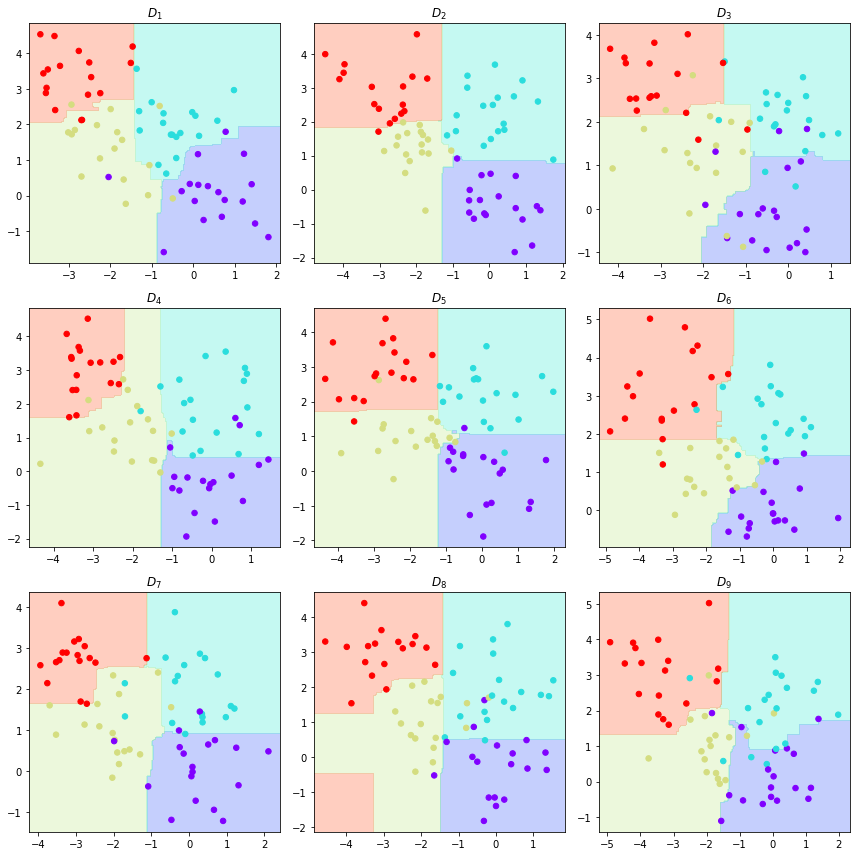

In [5]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
for j, ax in enumerate(ax.flat):
    X, y = make_blobs(n_samples=70, 
                      centers=centers, 
                      random_state=j, 
                      cluster_std=0.8)
    BT = BaggingTree(100, 50, max_depth=3)
    BT.fit(X,y)
    visualize_classifier(BT, X, y, ax, title=f"$D_{j+1}$")

plt.tight_layout()
plt.show()

It should be clear that we have a model with significantly less variance than using a single Decision tree classifier.

### Feature Bagging
So far, we have seen one type of randomization, namely that of randomizing across samples to create our bootstrap samples. Another important type of randomization is randomization across features (Random Forests implement both types of randomization). We now describe what it means to randomize across features. Assume that the inputs $x$ are $p$ dimensional vectors, so that we have $p$ features in total. Instead of training a base learner in $p$-dimensional space, we randomly pick a subset of $s < p$ features, and train the base classifier on just those. 

For example, if we have $p=10$ features, and $s=3$, we would randomly pick a subset of 3 features to look at, and train a decision tree on this reduced $3$ dimensional problem. We can view this as feature-bagging, as opposed to the sample-bagging we saw before. 

The goal of randomization is to make the resulting predictors (trained base classifiers) as independent of each other as possible, so that we get an overall reduction in variance. If only sample-bagging is performed, there is still a risk that all models will give more weight to the same features (those that seem important for this particular dataset), and so the trained classifiers end up being quite correlated. Randomizing features ensures that this does not happen.

Exercise:
1. Augment the `BaggingTree()` class to implement a feature-bagging method (call this resulting class RandomForest')

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

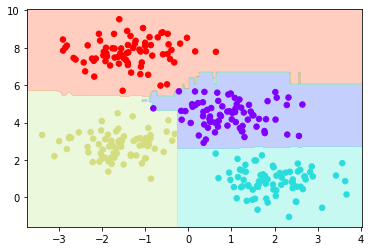

In [6]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_blobs(n_samples=300, centers=4,random_state=0, cluster_std=0.7)
model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X,y)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

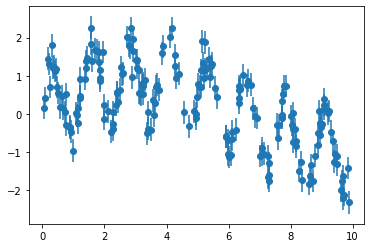

In [22]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

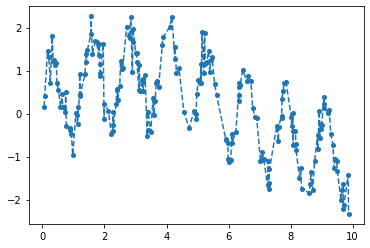

In [52]:
xs = np.argsort(x)
plt.plot(x[xs], y[xs], 'o--', markersize=4)

Using the random forest regressor, we can find the best fit curve as follows:

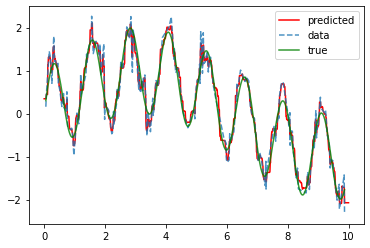

In [55]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.plot(xfit, yfit, '-r', label="predicted");
plt.plot(x[xs], y[xs], '--', label="data", alpha=0.8)

xx = np.linspace(np.min(x), np.max(x), 1000)
plt.plot(xx, model(xx, sigma=0), '-g', label="true", alpha=0.8)

plt.legend()
plt.show()

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously looked at the hand-written digits data, and we use that again here to see how the random forest classifier can be used in this context.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

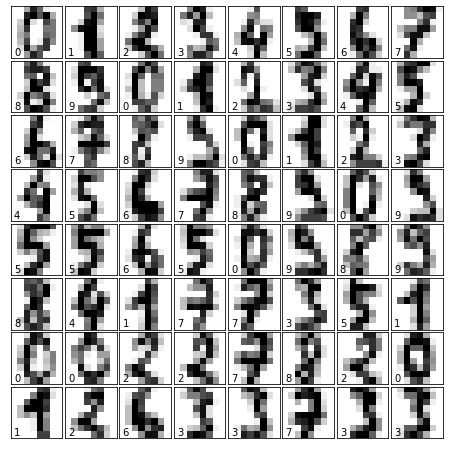

In [10]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [11]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:


In [12]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.98      1.00      0.99        43
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:


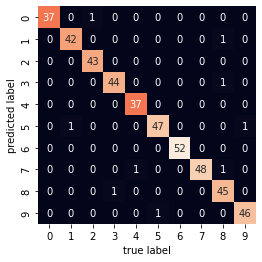

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

### Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.

**Question:** What advantages does the random forests method have?

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

**Question:** What disadvantages does random forests method have?

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

## Adaptive Boosting (AdaBoost)

Boosting is a different but equally important ensemble technique that has been extremely successful in machine learning. The idea here, as in Bagging, is to combine various base classifiers into a single classifier. The difference here though is that the classifiers are no longer required to be independent, in fact the classifiers are built in such a way that at each iteration, a classifier is trained on the mistakes of the previous classifier.

You should think about Adaptive Boosting as converting a weak learner (an algorithm that is able to achieve results that are slightly better than guessing) into a strong learner (an algorithm that can achieve a low error rate). In this lab we will consider Decision stumps as our weak learner (these are depth 1 decision trees, so just a single if statement (i.e. just a linear classifier)), and we will combine them to be able to learn complicated decision surfaces. We repeat here the AdaBoost pseudocode from lectures for reference, and defer mathematical detail to the tutorial.

Input: data $D=(X,y)$ where $X \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$, ensemble size $T$, learning algorithm $A$ (e.g. decision stump)

Output: weighted ensemble of models

1. Initialise weights: $w_{1i} \leftarrow \frac{1}{n}$ for $i=1,\dots,n$
2. for $t=1, \dots, T$:
    - run $A$ on $D$ with weights $w_{ti}$ to produce a model $M_t$
    - calculate weighted error $\epsilon_t = \frac{\sum_{i=1}^n w_{t-1,i} \mathbb{I}\{y_i \neq \hat{y}_i\}}{\sum_{i=1}^n w_{t-1,i}}$, where $\hat{y}_i = M_t(x_i)$
    - $\alpha_t \leftarrow \frac{1}{2} \log \frac{1-\epsilon_t}{\epsilon_t}$
    - $w_{(t+1)i} \leftarrow w_{ti} \exp(\alpha_t) $ for misclassified instances
    - $w_{(t+1)j} \leftarrow w_{ti}\exp(-\alpha_t)$ for correctly classified instances
3. return $M(x) = \text{sign} \left ( \sum_{t=1}^T \alpha_t M_t(x) \right )$

To describe this in words, in adaptive boosting, we build a model composed of $T$ weak learners from a set of weak learners. At step $t$, we pick a model from the set of weak learners that minimises weighted error, $\epsilon_t$ where $w_{t-1,i}$ is the weight at the previous step for observation $i$, and $\mathbb{I}\{y_i \neq \hat{y}_i\}$ is equal to $1$ if $y_i \neq \hat{y}_i$ and zero otherwise. We do this for a total of $T$ steps, which gives us a boosted model composed of $T$ base classifiers:
$$
M(x)= \sum_{t=1}^T \alpha_t M_t(x)
$$
where $\alpha_t$ is the weight assigned to the $t$-th model. Classification is then carried out by assigning a point to the positive class if $M(x)>0$ or to the negative class if $M(x)<1$.

We will now implement a simple Boosting Trees class from scratch. We can make use of the `sample_weight` argument in the `fit()` of the `DecisionTreeClassifier` method to assign different weights to the individual data points. 

(**note:** you may be concerned that the decision tree implementation in scikit learn does not actually minimise $\epsilon_t$ even when weights are assigned, but we will ignore this detail for now).

First, we will generate some data, and learn a decision stump (linear boundary), we will then imlpement our Boosting tree class and demonstrate its performance on the same dataset.

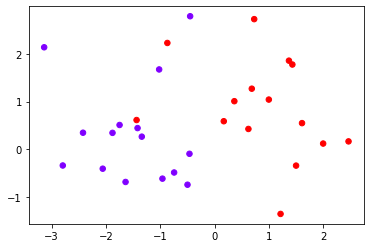

In [14]:
np.random.seed(2)
n_points = 30
X, y = make_blobs(n_points, 2, centers=[(-1,0.5), (1,0.5)])
plt.scatter(*X.T, c=y, s=30, cmap='rainbow')
plt.show()

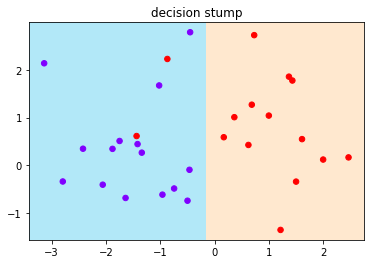

In [15]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)
visualize_classifier(dt, X, y, title='decision stump')

In [16]:
def weighted_error(w, y, yhat):
    return np.sum(w*(y != yhat))/np.sum(w)

class BoostingTrees():
    '''A (very) simple Boosting Tree Class'''
    
    def __init__(self, nComponents):
        self.nComponents = nComponents
        self.alphas = np.zeros(self.nComponents)
        self.baseClfs = []
    
    def fit(self, X, y):
        
        # make sure using {-1,1} coding for binary labels
        if np.any(y==0):
            y[y==0] = -1   
        
        n = X.shape[0]
        
        # store weights, initialise to uniform weight
        w = np.zeros((self.nComponents+1, n))
        w[0] = np.ones(n)/n
        
        # run boosting steps
        for t in range(self.nComponents):
            
            # select weak classifier (decision stumps) that minimises WEIGHTED error
            dt = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w[t])

            # compute predictions from current model
            yhat = dt.predict(X)

            # comptue weighted error epsilon_t
            eps_t = weighted_error(w[t], y, yhat)

            # compute alpha_t (model weight)
            alpha_t = 0.5 * np.log((1-eps_t)/eps_t)

            # update weights for next round 
            for i in range(n_points):
                if y[i] == yhat[i]: 
                    # correctly classified instances
                    w[t+1, i] = w[t, i] * np.exp(-1 * alpha_t)
                else:
                    # misclassified instances
                    w[t+1, i] = w[t, i] * np.exp(alpha_t)

            # save model 
            self.alphas[t] = alpha_t
            self.baseClfs.append(dt)
 
    def predict(self, x):
        # predict class of test point x by computing M(x) = sign(sum_t alpha_t M_t(x))
        # x must be a numpy array of shape (?, nfeatures), where ? is anything
        
        # make sure x is an array
        x = np.array(x)
        
        # avoid shape issues with single point predictions
        if len(x.shape) < 2:
            x = x.reshape(1,-1)
        
        # compute individual predictions
        ind_preds = np.array([m.predict(x) for m in self.baseClfs])
        
        # weight individual predictions by alphas
        weighted_preds = np.dot(self.alphas, ind_preds)
        
        # predictions are signs of weighted_preds
        preds = np.sign(weighted_preds)
        
        return preds        

Let's try out this class for an increasing number of components from $2,\dots,26$. We will see that we will be able to combine many linear classifiers (decision stumps) to be able to learn complicated decision surfaces in an automated fashion. 

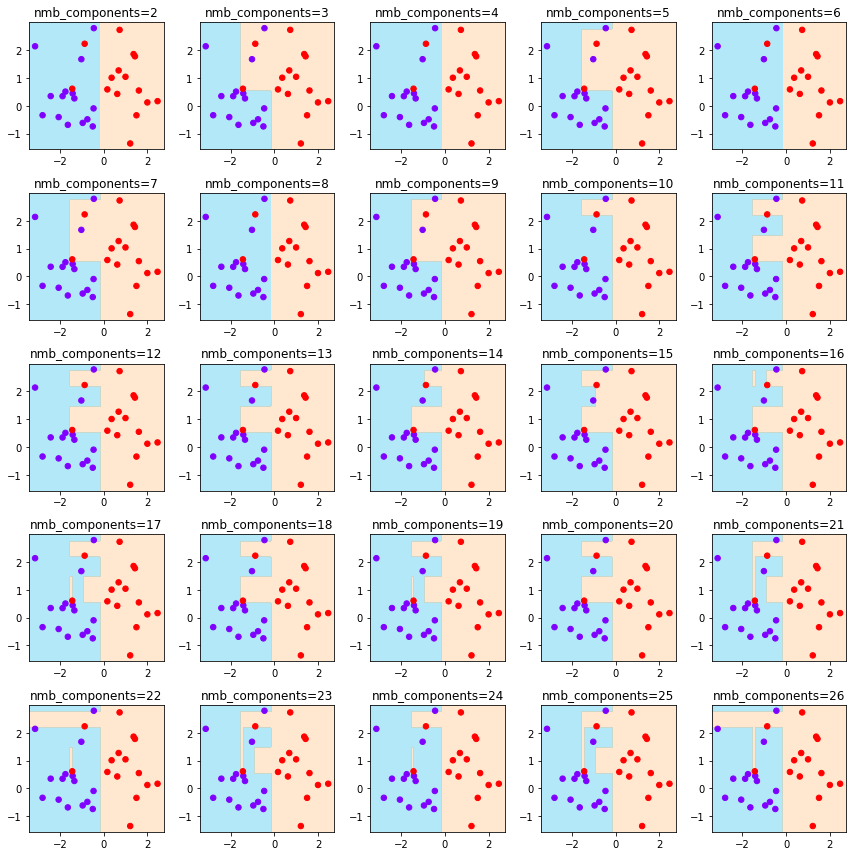

In [17]:
fig, ax = plt.subplots(5,5, figsize=(12,12))
titles = [f"nmb_components={i}" for i in range(2,28)]
for i, ax in enumerate(ax.flat):
    BT = BoostingTrees(nComponents=i+2)
    BT.fit(X,y)
    visualize_classifier(BT, X, y, ax, title=titles[i])
plt.tight_layout()
plt.show()

## Example: Boosted Trees for Classifying Digits

In practice, we will use the sklearn implementation of AdaBoost, and here we re-run our digit classification analysis but using the AdaBoost class.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, criterion='entropy'),
                           n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:


In [20]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.63      0.87      0.73        31
           2       0.64      1.00      0.78        28
           3       0.89      0.83      0.86        48
           4       0.97      0.88      0.93        42
           5       0.94      0.90      0.92        50
           6       0.92      1.00      0.96        48
           7       0.83      0.98      0.90        41
           8       0.98      0.63      0.76        75
           9       0.85      0.78      0.82        51

    accuracy                           0.86       450
   macro avg       0.86      0.89      0.86       450
weighted avg       0.88      0.86      0.86       450



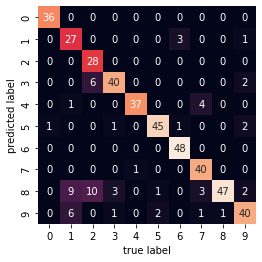

In [21]:
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');